# Ammenities Analysis: 
## Objective
- Handles data wranggling so as to transform data into a format suitbale for analysis and visualisation in Tableau.
- Exploratory Data Analysis into ammenities offered
- Text mining of Listing Descriptions to identify themes/topics which AirBnB owners use through n-grams analysis

## EDA Findings: 
### 1. The most common amenities Airbnb properties provide are:
- wireless internet
- smoke detector
- carbon monoxide detector
- fire extinguisher
- free parking on premises

### 2. After conducting a Chi Square Test to verify relationship between ammenities and price for ALL listings, 

- "property_type" has the highest chi-square statistic (6740.47), followed by "kitchen," "pool," and "doorman" indicating a strong association with prices.
- "property_type", "kitchen," "pool," "doorman," "heating," "gym," "hangers," "iron," and "breakfast" have p-values lower than 0.05 (close to 0), suggesting a significant association with prices
- In some cases, an association may be statistically significant but have negligible practical importance. For instance, while "cat", "essentials" has a low p-value, its association with prices might not be practically significant.

    
### 3. Identified amenities that are consistently offered by all Airbnb properties for each property type that fetch above-average prices (including less common ones).
   
### 4. Identifying amenities that are positively correlated with listings of high price:
   - washer
   - dryer
   - kitchen 
   - pool


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import ast
import re
from scipy.stats import pearsonr
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import networkx as nx


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', -1)


In [ ]:
listings = pd.read_csv('listings.csv')

# missing_zero_values_table(listings).head()

In [3]:
listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,1.672603,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,1.311040,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,1.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


In [4]:
listings = listings.drop(columns=['license','scrape_id','market','country','country_code','experiences_offered']).fillna(0)
# to drop license, scrape_id

In [5]:
listings.shape

(3818, 86)

In [6]:
listings_ammenities = listings[['id','space','transit','amenities']]
listings_ammenities

# clean ammenities 
def clean_amenities_col(df, column_name):
    df[column_name] = df[column_name].str.replace('[{} ]', '').str.lower()  # Remove quotes, braces, and spaces
    df[column_name] = df[column_name].str.split(',')  # Split the string into a list of amenities    
    
    return df

cleaned_listings_ammenities = clean_amenities_col(listings_ammenities, 'amenities')
# cleaned_listings_ammenities

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13172\2679631521.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace('[{} ]', '').str.lower()  # Remove quotes, braces, and spaces
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13172\2679631521.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].str.replace('[{} ]', '').str.lower()  # Remove quotes, braces, and spaces
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13172\2679631521.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [7]:
ammenities_only = cleaned_listings_ammenities[['id','amenities']]

ammenities_only['amenities_without_quotes'] = ammenities_only['amenities'].apply(lambda x: [item.strip('"') for item in x if len(item) > 0 and item[0] != '"'])
ammenities_only['amenities_within_quotes'] = ammenities_only['amenities'].apply(lambda x: [item.strip('"') for item in x if len(item) > 0 and item[0] == '"'])
ammenities_only['amenities_without_quotes_count'] = ammenities_only['amenities_without_quotes'].apply(len)
ammenities_only['amenities_within_quotes_count'] = ammenities_only['amenities_within_quotes'].apply(len)

ammenities_only.head(10)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13172\1559702995.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ammenities_only['amenities_without_quotes'] = ammenities_only['amenities'].apply(lambda x: [item.strip('"') for item in x if len(item) > 0 and item[0] != '"'])


,id,amenities,amenities_without_quotes,amenities_within_quotes,amenities_without_quotes_count,amenities_within_quotes_count
0,241032,"[tv, ""cabletv"", internet, ""wirelessinternet"", ""airconditioning"", kitchen, heating, ""family/kidfriendly"", washer, dryer]","[tv, internet, kitchen, heating, washer, dryer]","[cabletv, wirelessinternet, airconditioning, family/kidfriendly]",6,4
1,953595,"[tv, internet, ""wirelessinternet"", kitchen, ""freeparkingonpremises"", ""buzzer/wirelessintercom"", heating, ""family/kidfriendly"", washer, dryer, ""smokedetector"", ""carbonmonoxidedetector"", ""firstaidkit"", ""safetycard"", ""fireextinguisher"", essentials]","[tv, internet, kitchen, heating, washer, dryer, essentials]","[wirelessinternet, freeparkingonpremises, buzzer/wirelessintercom, family/kidfriendly, smokedetector, carbonmonoxidedetector, firstaidkit, safetycard, fireextinguisher]",7,9
2,3308979,"[tv, ""cabletv"", internet, ""wirelessinternet"", ""airconditioning"", kitchen, ""freeparkingonpremises"", ""petsallowed"", ""petsliveonthisproperty"", dog(s), cat(s), ""hottub"", ""indoorfireplace"", heating, ""family/kidfriendly"", washer, dryer, ""smokedetector"", ""carbonmonoxidedetector"", essentials, shampoo]","[tv, internet, kitchen, dog(s), cat(s), heating, washer, dryer, essentials, shampoo]","[cabletv, wirelessinternet, airconditioning, freeparkingonpremises, petsallowed, petsliveonthisproperty, hottub, indoorfireplace, family/kidfriendly, smokedetector, carbonmonoxidedetector]",10,11
3,7421966,"[internet, ""wirelessinternet"", kitchen, ""indoorfireplace"", heating, ""family/kidfriendly"", washer, dryer, ""smokedetector"", ""carbonmonoxidedetector"", ""safetycard"", ""fireextinguisher"", essentials, shampoo]","[internet, kitchen, heating, washer, dryer, essentials, shampoo]","[wirelessinternet, indoorfireplace, family/kidfriendly, smokedetector, carbonmonoxidedetector, safetycard, fireextinguisher]",7,7
4,278830,"[tv, ""cabletv"", internet, ""wirelessinternet"", kitchen, heating, ""family/kidfriendly"", ""smokedetector"", ""carbonmonoxidedetector"", ""firstaidkit"", ""fireextinguisher"", essentials, shampoo]","[tv, internet, kitchen, heating, essentials, shampoo]","[cabletv, wirelessinternet, family/kidfriendly, smokedetector, carbonmonoxidedetector, firstaidkit, fireextinguisher]",6,7
5,5956968,"[""wirelessinternet"", ""freeparkingonpremises"", heating, ""smokedetector"", essentials, shampoo]","[heating, essentials, shampoo]","[wirelessinternet, freeparkingonpremises, smokedetector]",3,3
6,1909058,"[""wirelessinternet"", ""freeparkingonpremises"", heating, ""smokedetector"", ""firstaidkit"", essentials, shampoo]","[heating, essentials, shampoo]","[wirelessinternet, freeparkingonpremises, smokedetector, firstaidkit]",3,4
7,856550,"[""wirelessinternet"", ""petsliveonthisproperty"", dog(s), heating, ""family/kidfriendly"", essentials, shampoo]","[dog(s), heating, essentials, shampoo]","[wirelessinternet, petsliveonthisproperty, family/kidfriendly]",4,3
8,4948745,"[tv, ""cabletv"", internet, ""wirelessinternet"", kitchen, breakfast, ""indoorfireplace"", heating, washer, dryer, ""smokedetector"", ""firstaidkit"", ""fireextinguisher"", essentials, shampoo]","[tv, internet, kitchen, breakfast, heating, washer, dryer, essentials, shampoo]","[cabletv, wirelessinternet, indoorfireplace, smokedetector, firstaidkit, fireextinguisher]",9,6
9,2493658,"[tv, internet, ""wirelessinternet"", kitchen, ""freeparkingonpremises"", ""buzzer/wirelessintercom"", heating, ""family/kidfriendly"", washer, dryer, ""smokedetector"", ""carbonmonoxidedetector"", ""firstaidkit"", ""safetycard"", ""fireextinguisher"", essentials]","[tv, internet, kitchen, heating, washer, dryer, essentials]","[wirelessinternet, freeparkingonpremises, buzzer/wirelessintercom, family/kidfriendly, smokedetector, carbonmonoxidedetector, firstaidkit, safetycard, fireextinguisher]",7,9


In [8]:
# ammenities_only.to_csv('ammenities_only.csv', index=False)

In [5]:
df = pd.read_csv('ammenities_only.csv')

In [24]:
categories = df[['id', 'amenities_without_quotes']]
detailed_cat = df[['id', 'amenities_within_quotes']]

In [25]:
def explode_df(categories, col):
    categories[col] = categories[col].apply(lambda x: ast.literal_eval(x))
    categories_exploded = categories.explode(col)
    categories.drop(col, axis=1, inplace=True)
    return categories_exploded

categories_exploded = explode_df(categories,"amenities_without_quotes")
categories_exploded.head(10)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17400\1810744467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categories[col] = categories[col].apply(lambda x: ast.literal_eval(x))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17400\1810744467.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categories.drop(col, axis=1, inplace=True)


,id,amenities_without_quotes
0,241032,tv
0,241032,internet
0,241032,kitchen
0,241032,heating
0,241032,washer
0,241032,dryer
1,953595,tv
1,953595,internet
1,953595,kitchen
1,953595,heating


In [26]:
detailed_cat_exploded = explode_df(detailed_cat,"amenities_within_quotes")
detailed_cat_exploded.head(20)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17400\1810744467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categories[col] = categories[col].apply(lambda x: ast.literal_eval(x))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17400\1810744467.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categories.drop(col, axis=1, inplace=True)


,id,amenities_within_quotes
0,241032,cabletv
0,241032,wirelessinternet
0,241032,airconditioning
0,241032,family/kidfriendly
1,953595,wirelessinternet
1,953595,freeparkingonpremises
1,953595,buzzer/wirelessintercom
1,953595,family/kidfriendly
1,953595,smokedetector
1,953595,carbonmonoxidedetector


In [27]:
categories_exploded.to_csv('categories_exploded.csv', index=False)
detailed_cat_exploded.to_csv('detailed_cat_exploded.csv', index=False)

## 1. Identifing basic amenities (frequently re-occuring amongst listings)

In [9]:
ammenities_only = pd.read_csv('ammenities_only.csv')  

In [10]:
# !pip install --upgrade scikit-learn


In [11]:
def get_word_occurrence(df, column_name):
    
    # Combine the values in the specified column into a single string
    amenities_data = df[[column_name]].apply(lambda x: ' '.join([item.strip("[]'") for item in x]))
    
    # Create an instance of CountVectorizer
    count_vectorizer = CountVectorizer()
    
    # Fit the CountVectorizer to the combined amenities data
    count_matrix = count_vectorizer.fit_transform(amenities_data)
    feature_names = count_vectorizer.get_feature_names_out()

    # Calculate the word occurrence by summing the count_matrix across the rows
    word_occurrence = count_matrix.sum(axis=0)
    
    # Create a dictionary with word and count
    word_occurrence_dict = {"Word": feature_names, "Count": word_occurrence.tolist()[0]}
    
    # Create a DataFrame from the word occurrence dictionary
    word_occurrence_df = pd.DataFrame(word_occurrence_dict)
    
    # Group the DataFrame by count and combine the words into a single row
    grouped_df = word_occurrence_df.groupby("Count")["Word"].apply(lambda x: ' '.join(x)).reset_index()
    grouped_df.columns = ["Count", "Words"]
    
    # Sort the DataFrame by count in descending order
    grouped_df = grouped_df.sort_values(by="Count", ascending=False)
    
    # Reset the index of the DataFrame
    grouped_df = grouped_df.reset_index(drop=True)
    
    return word_occurrence_df


In [12]:
basic_amenities_within_quotes = get_word_occurrence(ammenities_only, 'amenities_within_quotes')
basic_amenities_within_quotes

,Word,Count
0,24,616
1,airconditioning,677
2,buzzer,538
3,cabletv,1446
4,carbonmonoxidedetector,2485
5,dryer,2
6,elevatorinbuilding,785
7,family,1963
8,fireextinguisher,2196
9,firstaidkit,1680


In [13]:
basic_amenities_without_quotes = get_word_occurrence(ammenities_only, 'amenities_without_quotes')
basic_amenities_without_quotes

,Word,Count
0,breakfast,291
1,cat,382
2,dog,509
3,doorman,85
4,dryer,2997
5,essentials,3237
6,gym,442
7,hangers,846
8,heating,3627
9,internet,2811


In [14]:
# filtered_df = ammenities_only[ammenities_only['amenities_without_quotes'].str.contains('essentials')]

# filtered_df

## 2. Identifying common amenities that are offered by airbnbs fetching high prices for each property type

- high prices: above average prices for each property type
- common amenities: amenities appearing in all listings for each property type

In [15]:
def find_common_amenities(df, column_name):
    amenities = df[column_name].tolist()

    vectorizer = CountVectorizer()
    amenity_features = vectorizer.fit_transform(amenities)
    features_df = pd.DataFrame(amenity_features.toarray(), columns=vectorizer.get_feature_names_out())

    # Merge with original DataFrame
    merged_df = pd.concat([df[['id', 'price', 'property_type']].reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

    # Group by property type
    grouped_df = merged_df.groupby('property_type')

    # Find common and less common amenities for each property type
    for property_type, group in grouped_df:
        common_amenities = group.loc[:, group.eq(1).all()].columns.tolist()
        numeric_group = group.select_dtypes(include=[np.number])
        less_common_amenities = numeric_group.loc[:, numeric_group.sum() < len(numeric_group)].columns.tolist()

        print("Property Type:", property_type)
        print("Common Amenities:", common_amenities)
        print("Less Common Amenities:", less_common_amenities)
        print()


In [16]:
# only using price instead of weekly_price and monthly_price due to too many missing values 
listing_selected = listings[['id','review_scores_rating','property_type','room_type','price', 'weekly_price','monthly_price']]
#

def count_zeros(df):
    zero_counts = df.eq(0).sum()
    return zero_counts
print("-------------------------------------------------------------------------------------------")

print("missing values:")

print(count_zeros(listing_selected))
print("-------------------------------------------------------------------------------------------")

print("summary statistics:")


listing_selected.drop(['weekly_price', 'monthly_price'], axis=1, inplace=True)

# clean price column

listing_selected['price'] = listing_selected['price'].str.replace('$', '').str.replace(',', '')
listing_selected['price'] = listing_selected['price'].astype(float)

print(listing_selected.describe(include='all'))
print("-------------------------------------------------------------------------------------------")


-------------------------------------------------------------------------------------------
missing values:
id                      0   
review_scores_rating    647 
property_type           1   
room_type               0   
price                   0   
weekly_price            1809
monthly_price           2301
dtype: int64
-------------------------------------------------------------------------------------------
summary statistics:
                  id  review_scores_rating property_type        room_type  \
count   3.818000e+03  3818.000000           3818          3818              
unique NaN           NaN                    17            3                 
top    NaN           NaN                    House         Entire home/apt   
freq   NaN           NaN                    1733          2541              
mean    5.550111e+06  78.518596             NaN           NaN               
std     2.962660e+06  35.979061             NaN           NaN               
min     3.335000e+03  0.0

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13172\2482344334.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listing_selected.drop(['weekly_price', 'monthly_price'], axis=1, inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13172\2482344334.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  listing_selected['price'] = listing_selected['price'].str.replace('$', '').str.replace(',', '')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13172\2482344334.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [17]:
listing_selected = listing_selected[['id','property_type','room_type', 'price']]

listing_selected['price'] = listing_selected['price'].astype(float).replace('[$,]', '', regex=True).astype(float).round(2)

# retain those with above average property prices
mean_prices = listing_selected.groupby('property_type')['price'].transform('mean').round(2)
above_avg = listing_selected[listing_selected['price'] > mean_prices]

# combining dataframes
combined_aboveavg_df = above_avg.merge(ammenities_only, on='id', how='inner')
combined_aboveavg_df = combined_aboveavg_df[(combined_aboveavg_df['amenities_within_quotes_count'] != 0) & (combined_aboveavg_df['amenities_without_quotes_count'] != 0)]


In [18]:
combined_aboveavg_df_amenities_without_quotes = get_word_occurrence(combined_aboveavg_df, 'amenities_without_quotes')
combined_aboveavg_df_amenities_without_quotes

,Word,Count
0,breakfast,60
1,cat,74
2,dog,129
3,doorman,61
4,dryer,1160
5,essentials,1148
6,gym,265
7,hangers,304
8,heating,1292
9,internet,1074


In [19]:
combined_aboveavg_df.describe()

,id,price,amenities_without_quotes_count,amenities_within_quotes_count
count,1.342000e+03,1342.000000,1342.000000,1342.000000
mean,5.285209e+06,210.767511,7.818927,7.883010
std,2.896553e+06,105.014645,2.041515,2.958655
min,9.531000e+03,41.000000,1.000000,1.000000
25%,2.956416e+06,150.000000,7.000000,6.000000
50%,5.683054e+06,175.000000,8.000000,8.000000
75%,7.679733e+06,240.000000,9.000000,10.000000
max,1.033914e+07,1000.000000,13.000000,17.000000


In [20]:
column_name = 'amenities_without_quotes'
df = combined_aboveavg_df[['id', 'amenities_without_quotes', 'price','property_type']]

find_common_amenities(df, column_name)

Property Type: Apartment
Common Amenities: []
Less Common Amenities: ['breakfast', 'cat', 'dog', 'doorman', 'dryer', 'essentials', 'gym', 'hangers', 'heating', 'internet', 'iron', 'kitchen', 'pool', 'shampoo', 'tv', 'washer']

Property Type: Bed & Breakfast
Common Amenities: ['heating']
Less Common Amenities: ['breakfast', 'cat', 'dog', 'doorman', 'dryer', 'essentials', 'gym', 'hangers', 'internet', 'iron', 'kitchen', 'pool', 'shampoo', 'tv', 'washer']

Property Type: Boat
Common Amenities: ['dryer', 'essentials', 'heating', 'kitchen', 'tv']
Less Common Amenities: ['breakfast', 'cat', 'dog', 'doorman', 'gym', 'hangers', 'internet', 'iron', 'pool', 'shampoo', 'washer']

Property Type: Bungalow
Common Amenities: ['essentials', 'heating', 'internet', 'kitchen']
Less Common Amenities: ['breakfast', 'cat', 'dog', 'doorman', 'dryer', 'gym', 'hangers', 'iron', 'pool', 'shampoo', 'tv', 'washer']

Property Type: Cabin
Common Amenities: ['essentials', 'heating']
Less Common Amenities: ['breakfas

In [21]:
column_name = 'amenities_within_quotes'
df = combined_aboveavg_df[['id', 'amenities_within_quotes', 'price','property_type']]

find_common_amenities(df, column_name)

Property Type: Apartment
Common Amenities: []
Less Common Amenities: ['24', 'airconditioning', 'buzzer', 'cabletv', 'carbonmonoxidedetector', 'dryer', 'elevatorinbuilding', 'family', 'fireextinguisher', 'firstaidkit', 'freeparkingonpremises', 'hairdryer', 'hottub', 'hourcheck', 'in', 'indoorfireplace', 'kidfriendly', 'laptopfriendlyworkspace', 'lockonbedroomdoor', 'otherpet', 'petsallowed', 'petsliveonthisproperty', 'safetycard', 'smokedetector', 'smokingallowed', 'suitableforevents', 'washer', 'wheelchairaccessible', 'wirelessintercom', 'wirelessinternet']

Property Type: Bed & Breakfast
Common Amenities: ['wirelessinternet']
Less Common Amenities: ['24', 'airconditioning', 'buzzer', 'cabletv', 'carbonmonoxidedetector', 'dryer', 'elevatorinbuilding', 'family', 'fireextinguisher', 'firstaidkit', 'freeparkingonpremises', 'hairdryer', 'hottub', 'hourcheck', 'in', 'indoorfireplace', 'kidfriendly', 'laptopfriendlyworkspace', 'lockonbedroomdoor', 'otherpet', 'petsallowed', 'petsliveonthispr

## 3. Identifying amenities that are positively correlated to price among airbnbs fetching high prices

In [22]:
def calculate_correlations(df, target_column, amenity_columns):
    correlation_results = df[amenity_columns].corrwith(df[target_column]).sort_values(ascending=False)

    return correlation_results


In [23]:
flat_amenities = combined_aboveavg_df['amenities_without_quotes'].tolist()
flat_amenities2 = combined_aboveavg_df['amenities_within_quotes'].tolist()

In [24]:
vectorizer = CountVectorizer()
vectorizer.fit(flat_amenities)
amenity_features = vectorizer.transform(flat_amenities)
features_df = pd.DataFrame(amenity_features.toarray(), columns=vectorizer.get_feature_names_out())

merged_df0 = pd.concat([combined_aboveavg_df[['id','price','property_type']].reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)
merged_df0.fillna(0, inplace=True)

merged_df0.dropna(how='all', inplace=True)


In [25]:
amenity_columns = merged_df0.columns[3:]
df = merged_df0
target_column = 'price'
calculate_correlations(df, target_column, amenity_columns)

dryer         0.120759
washer        0.108382
tv            0.078228
doorman       0.053304
kitchen       0.052488
heating       0.031572
dog           0.029524
internet      0.024338
shampoo       0.013634
cat           0.006599
pool         -0.017837
hangers      -0.030343
iron         -0.034044
essentials   -0.035246
gym          -0.046136
breakfast    -0.050664
dtype: float64

## 4. Use Chi Square Test to verify relationship between ammenities and price for ALL listings.

In [26]:
vectorizer = CountVectorizer()
vectorizer.fit(flat_amenities2)
amenity_features2 = vectorizer.transform(flat_amenities2)
features_df2 = pd.DataFrame.sparse.from_spmatrix(amenity_features2, columns=vectorizer.get_feature_names_out())

features_df2
merged_df2 = pd.concat([combined_aboveavg_df[['id','price','property_type']].reset_index(drop=True), features_df2.reset_index(drop=True)], axis=1)

merged_df2.fillna(0, inplace=True)

target_column = 'price'
amenity_columns = merged_df2.columns[3:]
df= merged_df2
calculate_correlations(df, target_column, amenity_columns)

indoorfireplace            0.231132
freeparkingonpremises      0.155341
family                     0.155148
kidfriendly                0.155148
suitableforevents          0.150980
cabletv                    0.094638
firstaidkit                0.077813
airconditioning            0.074279
petsallowed                0.065428
hottub                     0.063569
carbonmonoxidedetector     0.031023
fireextinguisher           0.026498
safetycard                 0.018592
petsliveonthisproperty     0.016324
smokedetector              0.015154
otherpet                   0.014386
lockonbedroomdoor          0.013342
laptopfriendlyworkspace    0.001335
wirelessinternet          -0.003793
in                        -0.017634
hourcheck                 -0.017634
24                        -0.017634
dryer                     -0.021271
washer                    -0.021271
wheelchairaccessible      -0.027106
hairdryer                 -0.035879
smokingallowed            -0.043147
buzzer                    -0

In [27]:
from scipy.stats import chi2_contingency

listings_2 = listing_selected[['id', 'price', 'property_type']]
new_ammenities = listings_2.merge(ammenities_only, on='id', how='inner')

chi_without_quotes = new_ammenities.amenities_without_quotes.tolist()

vectorizer = CountVectorizer()
vectorizer.fit(chi_without_quotes)
chi_amenity_features = vectorizer.transform(flat_amenities)
chi_features_df = pd.DataFrame(chi_amenity_features.toarray(), columns=vectorizer.get_feature_names_out())

chi_merged_df = pd.concat([combined_aboveavg_df[['id','price','property_type']].reset_index(drop=True), chi_features_df.reset_index(drop=True)], axis=1)
chi_merged_df.fillna(0, inplace=True)

chi_merged_df.dropna(how='all', inplace=True)

chi_amenity_columns = chi_merged_df.columns[3:]

results = []
for amenity in chi_merged_df:
    contingency_table = pd.crosstab(chi_merged_df[amenity], chi_merged_df['price'])
    chi2, p, _, _ = chi2_contingency(contingency_table)

    results.append({'Amenity': amenity, 'Chi-square statistic': chi2, 'P-value': p})

results_df = pd.DataFrame(results)


In [28]:
results_df = results_df.drop(results_df.index[:2])
results_df = results_df.sort_values(by='P-value', ascending=True)

results_df

,Amenity,Chi-square statistic,P-value
2,property_type,6740.469610,0.000000e+00
14,kitchen,388.122379,7.526604e-18
15,pool,311.887873,1.635961e-09
6,doorman,309.071550,3.057819e-09
11,heating,301.151653,1.709819e-08
9,gym,271.819651,5.929176e-06
10,hangers,261.432583,3.775546e-05
13,iron,261.251780,3.894868e-05
3,breakfast,259.557825,5.203244e-05
5,dog,223.246804,1.054646e-02


In [29]:
chi_merged_df

,id,price,property_type,breakfast,cat,dog,doorman,dryer,essentials,gym,hangers,heating,internet,iron,kitchen,pool,shampoo,tv,washer
0,953595,150.0,Apartment,0,0,0,0,1,1,0,0,1,1,0,1,0,0,1,1
1,3308979,975.0,House,0,1,1,0,1,1,0,0,1,1,0,1,0,1,1,1
2,278830,450.0,House,0,0,0,0,0,1,0,0,1,1,0,1,0,1,1,0
3,2493658,150.0,Apartment,0,0,0,0,1,1,0,0,1,1,0,1,0,0,1,1
4,3883392,245.0,Apartment,0,0,0,0,1,1,0,0,1,1,0,1,0,1,1,1
5,8889257,165.0,House,0,0,0,0,1,1,0,0,1,1,0,1,0,1,1,1
6,5680462,461.0,House,0,0,0,0,1,1,0,0,1,1,0,1,0,1,1,1
7,7735464,200.0,Apartment,0,0,1,0,1,1,0,0,1,1,0,1,0,1,1,1
8,6291829,700.0,House,0,1,1,0,1,0,0,0,1,0,0,1,0,1,1,1
9,8942678,450.0,House,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1


In [30]:
listings_2 = listing_selected[['id', 'price', 'property_type']]
new_ammenities = listings_2.merge(ammenities_only, on='id', how='inner')

chi_without_quotes = new_ammenities.amenities_within_quotes.tolist()

vectorizer = CountVectorizer()
vectorizer.fit(chi_without_quotes)
chi_amenity_features = vectorizer.transform(flat_amenities)
chi_features_df = pd.DataFrame(chi_amenity_features.toarray(), columns=vectorizer.get_feature_names_out())

chi_merged_df1 = pd.concat([combined_aboveavg_df[['id','price','property_type']].reset_index(drop=True), chi_features_df.reset_index(drop=True)], axis=1)
chi_merged_df1.fillna(0, inplace=True)

chi_merged_df1.dropna(how='all', inplace=True)

chi_amenity_columns = chi_merged_df1.columns[3:]

results = []
for amenity in chi_merged_df:
    contingency_table = pd.crosstab(chi_merged_df[amenity], chi_merged_df['price'])
    chi2, p, _, _ = chi2_contingency(contingency_table)

    results.append({'Amenity': amenity, 'Chi-square statistic': chi2, 'P-value': p})

results_df = pd.DataFrame(results)


In [31]:
chi_merged_df1

,id,price,property_type,24,airconditioning,buzzer,cabletv,carbonmonoxidedetector,dryer,elevatorinbuilding,family,fireextinguisher,firstaidkit,freeparkingonpremises,hairdryer,hottub,hourcheck,in,indoorfireplace,kidfriendly,laptopfriendlyworkspace,lockonbedroomdoor,otherpet,petsallowed,petsliveonthisproperty,safetycard,smokedetector,smokingallowed,suitableforevents,washer,wheelchairaccessible,wirelessintercom,wirelessinternet
0,953595,150.0,Apartment,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,3308979,975.0,House,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,278830,450.0,House,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2493658,150.0,Apartment,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,3883392,245.0,Apartment,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,8889257,165.0,House,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6,5680462,461.0,House,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,7735464,200.0,Apartment,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8,6291829,700.0,House,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,8942678,450.0,House,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [32]:
results_df = results_df.drop(results_df.index[:2])
results_df = results_df.sort_values(by='P-value', ascending=True)

results_df

,Amenity,Chi-square statistic,P-value
2,property_type,6740.469610,0.000000e+00
14,kitchen,388.122379,7.526604e-18
15,pool,311.887873,1.635961e-09
6,doorman,309.071550,3.057819e-09
11,heating,301.151653,1.709819e-08
9,gym,271.819651,5.929176e-06
10,hangers,261.432583,3.775546e-05
13,iron,261.251780,3.894868e-05
3,breakfast,259.557825,5.203244e-05
5,dog,223.246804,1.054646e-02


# Text mining of descriptions

In [33]:
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import collections

def preprocess_text(df, text_column_name, new_column_name):
    stop_words = set(stopwords.words('english'))

    # Tokenize, remove stopwords, punctuation, and lowercase the text
    df[new_column_name] = df[text_column_name].apply(lambda x: ' '.join([word.lower().translate(str.maketrans('', '', string.punctuation)) for word in word_tokenize(str(x)) if word.lower() not in stop_words and word.isalpha()]))

    return df

# bigrams
def extract_bigrams(df, text_column_name, new_column_name):
    df[new_column_name] = df[text_column_name].apply(lambda x: list(ngrams(word_tokenize(x), 2)))
    return df

# tf-idf on bigrams 
def analyze_bigrams(df, text_column_name, bigram_column_name):
    # Preprocess the text and extract bigrams
    df['processed'] = df[text_column_name].apply(lambda x: ' '.join(word_tokenize(str(x).lower())))
    df['bigrams_extracted'] = df['processed'].apply(lambda x: list(ngrams(word_tokenize(x), 2)))
    
    # Flatten the list of bigrams
    flattened_bigrams = [bigram for sublist in df['bigrams_extracted'] for bigram in sublist]
    
    # Compute TF-IDF scores
    vectorizer = TfidfVectorizer(ngram_range=(2, 2))
    tfidf_matrix = vectorizer.fit_transform(df['processed'])
    
    # Get feature names (bigrams)
    feature_names = vectorizer.get_feature_names()
    sorted_bigrams = sorted(zip(feature_names, tfidf_matrix[0].toarray()[0]), key=lambda x: x[1], reverse=True)

    
    # Iterate over each bigram and its TF-IDF score
    for bigram, tfidf_score in sorted_bigrams:
        print(f"Bigram: {bigram}, TF-IDF Score: {tfidf_score}")
    
    return df

# trigrams
def extract_trigrams(df, text_column_name, new_column_name):
    df[new_column_name] = df[text_column_name].apply(lambda x: list(ngrams(word_tokenize(x), 3)))
    return df

# tf-idf on trigrams 
def analyze_trigrams(df, text_column_name, bigram_column_name):
    # Preprocess the text and extract bigrams
    df['processed'] = df[text_column_name].apply(lambda x: ' '.join(word_tokenize(str(x).lower())))
    df['bigrams_extracted'] = df['processed'].apply(lambda x: list(ngrams(word_tokenize(x), 3)))
    
    # Flatten the list of bigrams
    flattened_bigrams = [bigram for sublist in df['bigrams_extracted'] for bigram in sublist]
    
    # Compute TF-IDF scores
    vectorizer = TfidfVectorizer(ngram_range=(2, 2))
    tfidf_matrix = vectorizer.fit_transform(df['processed'])
    
    # Get feature names (bigrams)
    feature_names = vectorizer.get_feature_names()
    sorted_bigrams = sorted(zip(feature_names, tfidf_matrix[0].toarray()[0]), key=lambda x: x[1], reverse=True)

    
    # Iterate over each bigram and its TF-IDF score
    for bigram, tfidf_score in sorted_bigrams:
        print(f"Bigram: {bigram}, TF-IDF Score: {tfidf_score}")
    
    return df


In [34]:
space_working = cleaned_listings_ammenities[['id','space']]
space_working.head(20)


,id,space
0,241032,"Make your self at home in this charming one-bedroom apartment, centrally-located on the west side of Queen Anne hill. This elegantly-decorated, completely private apartment (bottom unit of a duplex) has an open floor plan, bamboo floors, a fully equipped kitchen, a TV, DVD player, basic cable, and a very cozy bedroom with a queen-size bed. The unit sleeps up to four (two in the bedroom and two on the very comfortable fold out couch, linens included) and includes free WiFi and laundry. The apartment opens onto a private deck, complete with it's own BBQ, overlooking a garden and a forest of black bamboo. The Apartment is perfectly-located just one block from the bus lines where you can catch a bus and be downtown Seattle in fifteen minutes or historic Ballard in ten or a quick five-minute walk will bring you to Whole Foods and Peet's Coffee or take a fifteen minute walk to the top of Queen Anne Hill where you will find a variety of eclectic shops, bars, and restaurants. There is no"
1,953595,"Beautiful, hypoallergenic apartment in an extremely safe, quiet and pedestrian-friendly section of Queen Anne. A leafy-green location that puts the best of Seattle at your doorstep. Free WiFi, free parking, ...even free pillows! What's special about this place? Hypo-allergenic bedding, mattresses/covers and new pillows with each rental. (So feel free to take your new pillows with you!) A beautiful restoration mixing period details & modern sensibilities: Hardwood floors throughout, white subway tile, low/no VOCs & non-toxic paints keep this home-away-from-home clean, smart and healthy. Radiant heat and oil radiators mean no blowing hot air or dust. Great Amenities: Free WiFi & internet TV (LED flatscreen). Fully-equipped kitchen with stainless-steel appliances, sink & disposal. Large washer & dryer. Iron/ironing board. Hairdryer. Plenty of storage. Convenient parking, both on- and off-street. The Best Location: Enjoy Seattle's celebrated Macrina bakery, neighborhood cafes, boutiqu"
2,3308979,"Our house is modern, light and fresh with a warm simple palette accented with barnwood, steel and concrete. Open living spaces for entertaining, gourmet kitchen, deck off the kitchen, reading nook, half bath and smaller tv room off kitchen. Fireplace with sofa and sitting area. Basement room is great for kids...this room has patio access and a garage door that opens into the space with basketball hoop right outside. A queen bedroom and full bath are in the basement with concrete heated floors. A queen sleeper sofa is in the tv area in the basement. This room has a door if privacy is needed. Great for a second family with kids. The 2nd floor has 4 bedrooms (one queen in master, one twin bedroom, another bedroom has twin bunk beds and the last bedroom has a queen bed. Their are 2 full baths, both with double sinks on this floor(one in the master). The 3rd floor is a very large deck, hot tub, kitchen prep area with fridge, lounge space for movies and 3/4 bath (rain head shower)."
3,7421966,0
4,278830,"Cozy family craftman house in beautiful neighborhood of Queen Anne, Seattle, Washinton. 3 bedrooms, can accomodate up to 6 people. 1,200 sq. feet space is your oasis. Perfect location, walking distance to Whole Foods Market, a 7 minute drive from the Seattle Center (Space Needle, chihuly garden and glass, Children's Museum, Key Arena)! Across the street from golf course- 2 min walk! Relax, sun bath and watch the ferry boats go by on the large outdoor deck with a view of Elliot Bay!"
5,5956968,"If you include a bit of your background in your housing request, you'll get a better chance to have it accepted. If you're an artist or musician wanting some more space to create, let me know. As far as the physical space, the room and bathroom are separate from the rest of the house so you'll have as much privacy as you wish. It doesn't have a TV but hopefully, you'll find more interesting things in Seattle to take your time."
6,1909058,"Enjoy a qu

In [35]:
#  text preprocessing (remove stopwords, non punctuation and lower all the caps)
space_working_cleaned = preprocess_text(space_working, 'space', 'processed')
space_working_2 = extract_bigrams(space_working_cleaned, 'processed', 'bigrams_extracted')
space_working_2.head(20)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13172\4226685557.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_column_name] = df[text_column_name].apply(lambda x: ' '.join([word.lower().translate(str.maketrans('', '', string.punctuation)) for word in word_tokenize(str(x)) if word.lower() not in stop_words and word.isalpha()]))


,id,space,processed,bigrams_extracted
0,241032,"Make your self at home in this charming one-bedroom apartment, centrally-located on the west side of Queen Anne hill. This elegantly-decorated, completely private apartment (bottom unit of a duplex) has an open floor plan, bamboo floors, a fully equipped kitchen, a TV, DVD player, basic cable, and a very cozy bedroom with a queen-size bed. The unit sleeps up to four (two in the bedroom and two on the very comfortable fold out couch, linens included) and includes free WiFi and laundry. The apartment opens onto a private deck, complete with it's own BBQ, overlooking a garden and a forest of black bamboo. The Apartment is perfectly-located just one block from the bus lines where you can catch a bus and be downtown Seattle in fifteen minutes or historic Ballard in ten or a quick five-minute walk will bring you to Whole Foods and Peet's Coffee or take a fifteen minute walk to the top of Queen Anne Hill where you will find a variety of eclectic shops, bars, and restaurants. There is no",make self home charming apartment west side queen anne hill completely private apartment bottom unit duplex open floor plan bamboo floors fully equipped kitchen tv dvd player basic cable cozy bedroom bed unit sleeps four two bedroom two comfortable fold couch linens included includes free wifi laundry apartment opens onto private deck complete bbq overlooking garden forest black bamboo apartment one block bus lines catch bus downtown seattle fifteen minutes historic ballard ten quick walk bring whole foods peet coffee take fifteen minute walk top queen anne hill find variety eclectic shops bars restaurants,"[(make, self), (self, home), (home, charming), (charming, apartment), (apartment, west), (west, side), (side, queen), (queen, anne), (anne, hill), (hill, completely), (completely, private), (private, apartment), (apartment, bottom), (bottom, unit), (unit, duplex), (duplex, open), (open, floor), (floor, plan), (plan, bamboo), (bamboo, floors), (floors, fully), (fully, equipped), (equipped, kitchen), (kitchen, tv), (tv, dvd), (dvd, player), (player, basic), (basic, cable), (cable, cozy), (cozy, bedroom), (bedroom, bed), (bed, unit), (unit, sleeps), (sleeps, four), (four, two), (two, bedroom), (bedroom, two), (two, comfortable), (comfortable, fold), (fold, couch), (couch, linens), (linens, included), (included, includes), (includes, free), (free, wifi), (wifi, laundry), (laundry, apartment), (apartment, opens), (opens, onto), (onto, private), (private, deck), (deck, complete), (complete, bbq), (bbq, overlooking), (overlooking, garden), (garden, forest), (forest, black), (black, bamboo), (bamboo, apartment), (apartment, one), (one, block), (block, bus), (bus, lines), (lines, catch), (catch, bus), (bus, downtown), (downtown, seattle), (seattle, fifteen), (fifteen, minutes), (minutes, historic), (historic, ballard), (ballard, ten), (ten, quick), (quick, walk), (walk, bring), (bring, whole), (whole, foods), (foods, peet), (peet, coffee), (coffee, take), (take, fifteen), (fifteen, minute), (minute, walk), (walk, top), (top, queen), (queen, anne), (anne, hill), (hill, find), (find, variety), (variety, eclectic), (eclectic, shops), (shops, bars), (bars, restaurants)]"
1,953595,"Beautiful, hypoallergenic apartment in an extremely safe, quiet and pedestrian-friendly section of Queen Anne. A leafy-green location that puts the best of Seattle at your doorstep. Free WiFi, free parking, ...even free pillows! What's special about this place? Hypo-allergenic bedding, mattresses/covers and new pillows with each rental. (So feel free to take your new pillows with you!) A beautiful restoration mixing period details & modern sensibilities: Hardwood floors throughout, white subway tile, low/no VOCs & non-toxic paints keep this home-away-from-home clean, smart and healthy. Radiant heat and oil radiators mean no blowing hot air or dust. Great Amenities: Free WiFi & internet TV (LED flatscreen). Fully-equipped kitchen with st

## 1. Query the top 20 most common bigrams across descriptions

In [36]:
# flatten list of bigrams
bigrams = [bigram for sublist in space_working_2['bigrams_extracted'] for bigram in sublist]
bigram_counts = collections.Counter(bigrams)
bigram_df = pd.DataFrame(bigram_counts.most_common(35),
                             columns=['bigram', 'count'])
bigram_df


,bigram,count
0,"(living, room)",855
1,"(downtown, seattle)",429
2,"(queen, bed)",408
3,"(size, bed)",357
4,"(capitol, hill)",352
5,"(walking, distance)",348
6,"(queen, size)",342
7,"(place, market)",309
8,"(pike, place)",304
9,"(washer, dryer)",245


## 2. Visualise bigrams and the relationships they share

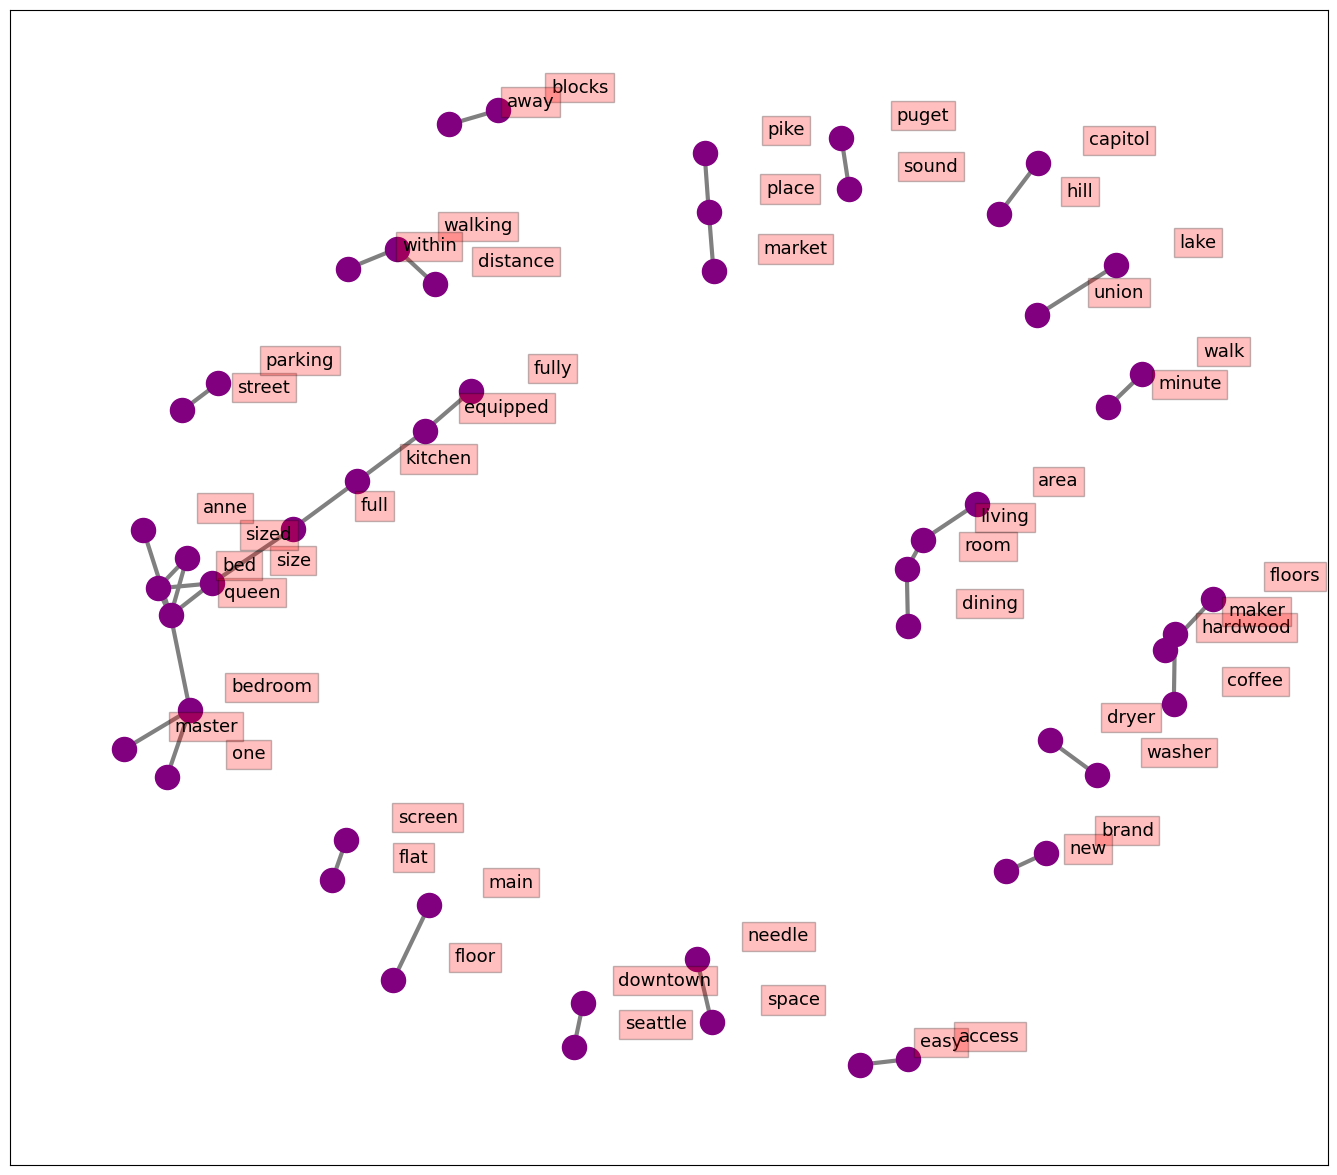

In [37]:
import matplotlib.pyplot as plt
import networkx as nx

d = bigram_df.set_index('bigram').T.to_dict('records')
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))


fig, ax = plt.subplots(figsize=(17, 15))

pos = nx.spring_layout(G, k=3)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.145, value[1]+.035
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)

# plt.savefig("Bigram_Graph.png", format="PNG")
# plt.show()


## 3. Query the top 20 most common trigrams across descriptions

In [38]:
space_working_3 = extract_trigrams(space_working_cleaned, 'processed', 'trigrams_extracted')
# flatten list of bigrams
trigrams = [bigram for sublist in space_working_3['trigrams_extracted'] for bigram in sublist]
trigrams_counts = collections.Counter(trigrams)
trigrams_df = pd.DataFrame(trigrams_counts.most_common(35),
                             columns=['trigram', 'count'])

In [39]:
trigrams_df

,trigram,count
0,"(pike, place, market)",275
1,"(queen, size, bed)",215
2,"(within, walking, distance)",166
3,"(fully, equipped, kitchen)",128
4,"(flat, screen, tv)",104
5,"(queen, sized, bed)",102
6,"(bedroom, queen, bed)",92
7,"(full, size, bed)",71
8,"(open, floor, plan)",69
9,"(south, lake, union)",68
